# Labeling Measurements

MVG comes with a labeling API that allows a user to store important information about a measurement. There are multiple reasons why you would want to label measurements and some of the benefits include

- Additional information about modes. For example, a mode with multiple critical measurements is likely a failure mode
- Improved mode detection
- As personal notes for keeping track of interesting events in the data

This example will go through how what a label is in MVG and how the labeling API functions. 

### Prerequisites

To follow this example you need to have

- Installed `mvg` package
- A token for API access from Viking Analytics
- The database needs to be populated with our example assets. This can be achieved by running the ["Sources and Measurement"](sources_and_measurements.ipynb) example.

## Import the required packages and functions

In [1]:
import os
from mvg import MVG
from mvg.plotting import plot_labels_over_time

## Create a session for API access

Note that the `TOKEN` is used both for authorization and authentication. Thus, each unique token represents a unique user and each user has their own unique database on the Viking Analytics MultiViz Vibration service.

**You need to insert your token received from Viking Analytics here:**

In [2]:
TOKEN = os.environ["TEST_TOKEN"]
URL = "https://api.beta.multiviz.com"
session = MVG(URL, TOKEN)

session.check_version()

{'api_version': '0.2.4',
 'mvg_highest_tested_version': '0.2.3',
 'mvg_version': '0.9.4'}

## Adding labels

Once the API session is live, we start by checking if the source `u0001` we will use is available in the database.

In [3]:
SOURCE_ID = "u0001"
session.get_source(SOURCE_ID)

{'source_id': 'u0001',
 'meta': {'assetId': 'assetA', 'measPoint': 'mloc01', 'location': 'paris'},
 'properties': {'data_class': 'waveform', 'channels': ['acc']}}

Now that we know that the source exists we need to check it's measurements to know which ones to label

In [4]:
measurements = session.list_measurements(SOURCE_ID)
measurements[:3]

[{'timestamp': 1570186860, 'meta': {}, 'duration': 2.8672073400507907},
 {'timestamp': 1570273260, 'meta': {}, 'duration': 2.8672073400507907},
 {'timestamp': 1570359660, 'meta': {}, 'duration': 2.8672073400507907}]

For this example let us say that there was a bearing failure of the machine in the first few measurements, so we will add some labels to the afflicted measurements. To do so we use the `MVG.create_label()` method.

A label in MVG relates to a specific measurement, which are identifiable by the source ID and the timestamp. Each measurement can only have one label. The label itself has three components

- A label identification string
- A severity level number
- And notes

The label identification string is unique for each label and is case and spelling sensitive, i.e. `"failure"` and `"Failure"` are not interpreted as the same label. The severity level is an integer where a larger number indicates a more severe problem. They do not need to be the same for different instances of the same label. The notes exist for the end user to add extra information to a certain label and is not used by MVG in any way.

In [5]:
for measurement in measurements[:3]:
    session.create_label(
        sid=SOURCE_ID,
        timestamp=measurement["timestamp"],
        label="bearing_failure",
        severity=3,
        notes="Imaginary bearing failure"
    )

## Reading Labels

To get a list of all the labels for a source we use the `MVG.list_labels()` method.

In [6]:
session.list_labels(SOURCE_ID)

[{'timestamp': 1570186860,
  'label': 'bearing_failure',
  'severity': 3,
  'notes': 'Imaginary bearing failure',
  'label_timestamp': '2021-10-15 09:46:51'},
 {'timestamp': 1570273260,
  'label': 'bearing_failure',
  'severity': 3,
  'notes': 'Imaginary bearing failure',
  'label_timestamp': '2021-10-15 09:46:51'},
 {'timestamp': 1570359660,
  'label': 'bearing_failure',
  'severity': 3,
  'notes': 'Imaginary bearing failure',
  'label_timestamp': '2021-10-15 09:46:51'}]

As you can see the measurements that we just added labels too show up. To inspect the label of a specific measurement we use `MVG.get_label()`

In [7]:
session.get_label(SOURCE_ID, measurements[0]["timestamp"])

{'label': 'bearing_failure',
 'severity': 3,
 'notes': 'Imaginary bearing failure',
 'label_timestamp': '2021-10-15 09:46:51'}

## Updating labels

Maybe we realized that the problem did not actually occur until the third timestamp and we want to change the labels for the first two. Then we use the `session.update_label()` method.

In [8]:
for measurement in measurements[:2]:
    session.update_label(
        sid=SOURCE_ID,
        timestamp=measurement["timestamp"],
        label="OK",
        severity=0,
        notes="This was an OK measurement"
    )

# List the labels again
labels = session.list_labels(SOURCE_ID)
labels

[{'timestamp': 1570186860,
  'label': 'OK',
  'severity': 0,
  'notes': 'This was an OK measurement',
  'label_timestamp': '2021-10-15 09:46:51'},
 {'timestamp': 1570273260,
  'label': 'OK',
  'severity': 0,
  'notes': 'This was an OK measurement',
  'label_timestamp': '2021-10-15 09:46:51'},
 {'timestamp': 1570359660,
  'label': 'bearing_failure',
  'severity': 3,
  'notes': 'Imaginary bearing failure',
  'label_timestamp': '2021-10-15 09:46:51'}]

## Plotting labels

To get an overview of the data and labels it can be very good to plot the labels over time. The `plotting` module of `mvg` contains the function `plot_labels_over_time` that does just that. The plot is very similar to that of the ModeId plots, so it is easy to compare results. We can add the `include_unlabeled=True` keyword to plot the unlabeled measurements as well.

[]

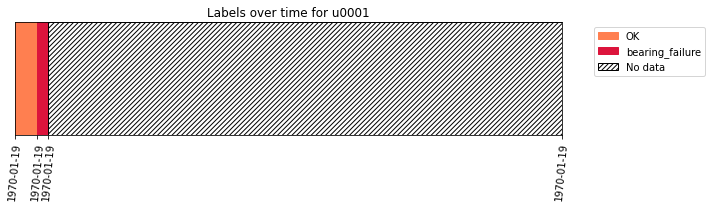

In [9]:
labels = session.list_labels(SOURCE_ID, include_unlabeled=True)
plot_labels_over_time(labels, SOURCE_ID)

As you can see we only labeled a small subset of the data. The idea is not to label all the measurements, but to label a part and then use that information to make inference about the unlabeled measurements. 

## Deleting labels

To delete labels we use the `MVG.delete_label()` method. Let's use that to remove our example labels to get back to a clean slate.

In [10]:
labels = session.list_labels(SOURCE_ID)
for label in labels:
    session.delete_label(SOURCE_ID, label["timestamp"])
print(f"Removed {len(labels)} labels")

Removed 3 labels
